# Prompt Difficulty via LLM-as-Judge

Prompt _quality_ is a measure of [how much a prompt is worth to Yupp](https://docs.google.com/document/d/1q-0K0Ub9X34jMMgGdfkmQQGYQNCLlHM0yg1rk2ROTH8/edit#heading=h.430u6iquvfh5). It can include several dimensions, including the prompt _difficulty_ (how complex it is for different LLMs to respond to it, and hence how good it is as a differentiator between them), as well as its _novelty_ (how much it contributes to Yupp, given already existing/evaluated prompts).

This notebook investigates determining the difficulty of prompts using an LLM-as-judge. Specifically, it:
* Develops ground-truth data for prompt difficulty
* Evaluates LLM-as-judge approaches to assessing difficulty using a data-driven metric

### Ground truth

We use two sources for ground-truth data of prompt difficulty:

1. **Benchmark data**: existing benchmarks that score the responses of multiple LLMs on a set of prompts. We will assume that the difficulty of these prompts is related to the number of LLMs successfully responding - "easy" prompts are answered by many LLMs, "hard" ones by few.
2. **Chatbot Arena**: we use Arena-Hard, a manually-reviewed, mostly-automated [set of 500 prompts](https://arxiv.org/abs/2406.11939) selected from Chatbot Arena as examples of "difficult" prompts, as examples of "hard" prompts. For "easy" prompts, we use prompts from the [LS Kaggle dataset](https://www.kaggle.com/competitions/lmsys-chatbot-arena) where weak models have won over strong models.

### Metric

To measure the success of a quality estimate, we measure the correlation between the estimate and the ground-truth judgments. We can use additional ones such as precision and recall, but directionally they're all similar, and we're using the metric to determine whether two approaches are improving on each other, rather than an absolute measure.

In [2]:
import ast
import json
import os
import sys
from typing import Any
from urllib.parse import unquote

import pandas as pd  # noqa: E402
import seaborn as sns
from datasets import load_dataset

sys.path.append("..")
from ypl.backend.llm.chat import (
    AIMessage,
    HumanMessage,
    JsonChatIO,
    YuppChatMessageHistory,
)

### Benchmark prompts
Fetch prompts and responses from [HELM-lite](https://crfm.stanford.edu/2023/12/19/helm-lite.html), a broad benchmark applied to hundreds of LLMs. 
```sh
pip install git+https://github.com/wschella/helm-data-downloader

helmdd --project lite --release latest --output-dir ./data/helm-data
```

In [3]:
# Helper functions for loading HELM-lite data

# JSON fields used by HELM to measure success of an LLM response.
metric_keys = [
    "exact_match",
    "f1_score",
    "math_equiv_chain_of_thought",
    "quasi_exact_match",
    "bleu_4",
    "final_number_exact_match",
]
inputs = {}
dfs = []


def extract_task_and_model(dir_name: str) -> tuple[str, str]:
    """Returns the HELM task name and the model evaluated from its directory path."""
    dir_name = unquote(dir_name).split("/")[-1]
    parts = dir_name.split("model=")
    task = parts[0].split(",")[0].strip(":")
    model = parts[1]
    return task, model


def get_predictions(display_predictions: list[dict[str, Any]]):
    """Extracts the mean of the metrics that are most highly correlated with human judgment."""

    def get_metric(pred: dict[str, Any]):
        for key in metric_keys:
            if key in pred["stats"]:
                return pred["stats"][key]
        return None

    return {pred["instance_id"]: get_metric(pred) for pred in display_predictions}


def get_inputs(instances):
    return {inst["id"]: inst["input"]["text"] for inst in instances}


def load_helm_data(dir: str) -> pd.DataFrame:
    """Loads HELM data from a directory."""
    task, model = extract_task_and_model(dir)
    predictions = get_predictions(json.load(open(f"{dir}/display_predictions.json")))
    df = pd.DataFrame({"prompt_id": predictions.keys(), "score": predictions.values()})
    df["task_id"] = task
    df["model"] = model
    if task not in inputs:
        inputs[task] = get_inputs(json.load(open(f"{dir}/instances.json")))
    return df


for dir in os.listdir("data/helm-data"):
    if "wmt_14" in dir:
        # Skip translations.
        continue
    dfs.append(load_helm_data(f"data/helm-data/{dir}"))

In [4]:
# Aggregate all HELM prompts and response success rates into a dataframe.

helm_df = pd.concat(dfs)
helm_df["prompt"] = helm_df.apply(lambda row: inputs[row.task_id][row.prompt_id], axis=1)
grouped = helm_df.groupby(["prompt_id", "task_id", "prompt"])
helm_df = grouped.agg({"score": ["mean", "median"]}).reset_index()
helm_df.columns = ["prompt_id", "task_id", "prompt", "mean_score", "median_score"]
helm_df = helm_df.sort_values("mean_score", ascending=False)

helm_df.head(3)

,prompt_id,task_id,prompt,mean_score,median_score
3098,id2436,natural_qa:mode=openbook_longans,Passage: The first series of The Great British...,1.0,1.0
4921,id4531,legalbench:subset=international_citizenship_qu...,Question: Consider the country of Peru. Does t...,1.0,1.0
4195,id3552,natural_qa:mode=closedbook,Who took the first steps on the moon in 1969?,1.0,1.0


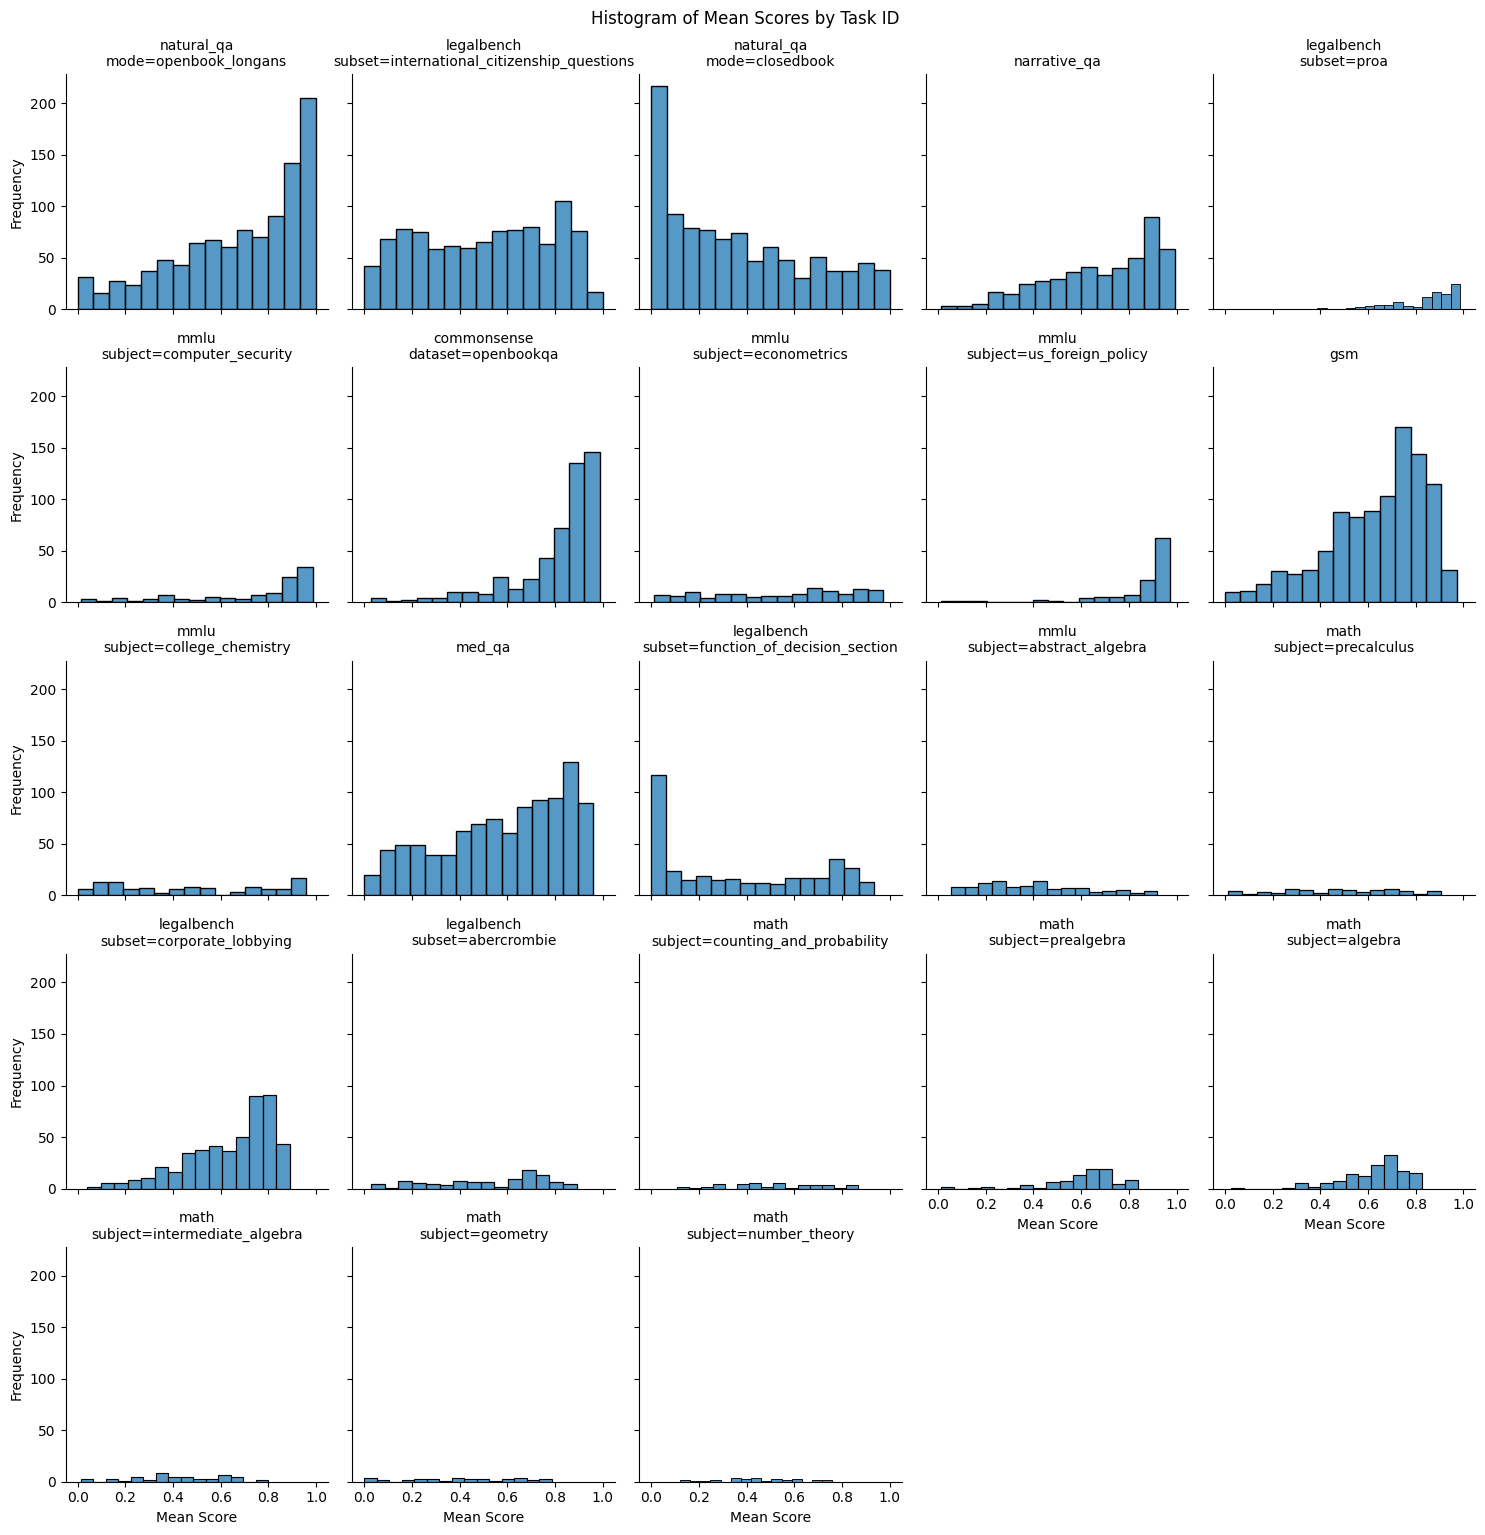

In [5]:
# Check which HELM task has a reasonable distribution of success rates across the prompts.

g = sns.FacetGrid(helm_df, col="task_id", col_wrap=5, sharex=True, sharey=True)
g.map(sns.histplot, "mean_score", bins=15)
g.set_axis_labels("Mean Score", "Frequency")
for ax in g.axes.flat:
    title = ax.get_title()
    new_title = title.replace("task_id = ", "").replace(":", "\n")
    ax.set_title(new_title, fontsize=10)
_ = g.fig.suptitle("Histogram of Mean Scores by Task ID", y=1.02)

Looking at the distributions above, we start with the `natural_qa:mode=closedbook` category, which has "difficulty" levels across the spectrum. This category includes questions such as:
* Who had a baby at 100 in the bible?
* Jharkhand which festival is associated with cattle worship?
* Where was the first nhl hockey game played?

These are mostly factoid prompts, so we'll augment this with data from LS and WildChat later.

We'll collect low-difficulty and high-difficulty prompts from this category, by looking at prompts that have a success rate above 0.8 and below 0.2, respectively.

In [6]:
max_fraction_hard_prompts = 0.2
min_fraction_easy_prompts = 0.8

qa = helm_df[helm_df.task_id == "natural_qa:mode=closedbook"]
qa["id"] = qa.apply(lambda row: f"helm-{row.task_id}-{row.prompt_id}", axis=1)
# mean_score is the mean score of all LLMs for this prompt.
# the higher it is, the more LLMs have answered it successfully, and hence the easier it is.
hard = qa[qa.mean_score < max_fraction_hard_prompts]
easy = qa[qa.mean_score > min_fraction_easy_prompts]

helm_sample = pd.concat([easy.sample(50), hard.sample(50)])


def write_prompts(prompts: list[str], responses: list[tuple[str, str]], ids: list[str], output_file: str):
    """Write prompts to a file in a format used by `judge-yupp-prompt-difficulty`."""
    writer = JsonChatIO(output_file)
    for prompt, response_pair, id in zip(prompts, responses, ids, strict=True):
        chat = YuppChatMessageHistory(
            messages=[
                [HumanMessage(content=prompt)],
                [AIMessage(content=response_pair[0]), AIMessage(content=response_pair[1])],
            ],
            id=id,
        )
        writer.append_chat(chat)  # type: ignore
    writer.flush(mode="w")


helm_sample_jsonl = "data/helm_sample.jsonl"
write_prompts(
    helm_sample.prompt.tolist(),
    [("", "") for _ in helm_sample.prompt.tolist()],  # Don't use responses for HELM.
    helm_sample.id.tolist(),
    helm_sample_jsonl,
)

/var/folders/44/drs75klx55zg65dwd906jzq00000gn/T/ipykernel_18657/1151944096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qa["id"] = qa.apply(lambda row: f"helm-{row.task_id}-{row.prompt_id}", axis=1)


In [7]:
# This doesn't actually run the judge -- it provides a command that can be used on the cmd-line to run it.
def run_judge(input_file: str) -> str:
    output_file = input_file.replace(".jsonl", ".out.jsonl")
    print(
        f"""Please set OAI_KEY and run:

python -m ypl.cli judge-yupp-prompt-difficulty \\
  --config /dev/null \\
  --provider openai \\
  --api-key $OAI_KEY \\
  --language-model gpt-4o-mini \\
  --input-file notebooks/{input_file} \\
  --output-file notebooks/{output_file} \\
  --num-parallel 8
"""
    )
    return output_file


helm_sample_out = run_judge(helm_sample_jsonl)

Please set OAI_KEY and run:

python -m ypl.cli judge-yupp-prompt-difficulty \
  --config /dev/null \
  --provider openai \
  --api-key $OAI_KEY \
  --language-model gpt-4o-mini \
  --input-file notebooks/data/helm_sample.jsonl \
  --output-file notebooks/data/helm_sample.out.jsonl \
  --num-parallel 8



In [8]:
# Load the judgments.


def load_judgments(in_file: str, original_df: pd.DataFrame) -> pd.DataFrame:
    df = pd.read_json(in_file, lines=True)
    judgment_df = pd.json_normalize(df["judgement"])
    df = df.drop(columns=["judgement"]).join(judgment_df)
    eval_cols = [col for col in df.columns if col not in ["overall", "id"]]
    df["mean_judgement"] = df[eval_cols].mean(axis=1)
    return pd.merge(df, original_df, on="id")


helm_judged_df = load_judgments(helm_sample_out, helm_sample)
helm_judged_df.head(3)

,id,complexity,specificity,domain_knowledge,ambiguity,creativity,constraints,length,cognitive_load,response_consistency,completion_rate,quality_variance,interpretation_differences,overall,mean_judgement,prompt_id,task_id,prompt,mean_score,median_score
0,helm-natural_qa:mode=closedbook-id1290,2,3,2,2,1,1,1,2,1,5,1,1,3,1.833333,id1290,natural_qa:mode=closedbook,Where is wind power used most in the united st...,0.857845,1.0
1,helm-natural_qa:mode=closedbook-id1378,2,3,2,2,1,1,1,1,1,5,1,1,3,1.750000,id1378,natural_qa:mode=closedbook,Where did they live in sex and the city?,0.898095,1.0
2,helm-natural_qa:mode=closedbook-id2554,1,5,1,1,1,1,1,1,1,1,1,1,2,1.333333,id2554,natural_qa:mode=closedbook,How many lines of symmetry are there in a equi...,0.973333,1.0


In [9]:
# Sanity check; we expect the difficulty score for easy prompts to be lower than for hard prompts.

easy = helm_judged_df[helm_judged_df.mean_score > min_fraction_easy_prompts]
hard = helm_judged_df[helm_judged_df.mean_score < max_fraction_hard_prompts]

print(f"Mean score across LLMs for easy prompts: {easy.overall.mean()} ± {easy.overall.std()}")
print(f"Mean score across LLMs for hard prompts: {hard.overall.mean()} ± {hard.overall.std()}")

print("\nExample hard HELM prompts:")
for i in range(5):
    prompt = hard.iloc[i]["prompt"].replace("\n", "  ").strip()
    print(f"- {prompt}")
print("\nExample easy HELM prompts:")
for i in range(5):
    prompt = easy.iloc[i]["prompt"].replace("\n", "  ").strip()
    print(f"- {prompt}")

Mean score across LLMs for easy prompts: 2.18 ± 1.0437373975775903
Mean score across LLMs for hard prompts: 3.12 ± 1.4090089149643374

Example hard HELM prompts:
- Who is the guy on keeping up with the kardashians?
- How can you remove the defect of vision presbyopia?
- When was the wheel introduced to north america?
- Who sings the theme tune to mum on bbc2?
- Who controlled the house and the senate in 2012?

Example easy HELM prompts:
- Where is wind power used most in the united states?
- Where did they live in sex and the city?
- How many lines of symmetry are there in a equilateral triangle?
- Who was the inventor who developed a way to record sound?
- Who is in charge of ratifying treaties in the us?


In [10]:
def eval_quality(df: pd.DataFrame, quality_col: str, score_col: str):
    """The accuracy is just the correlation between the judgments and the "ground truth" column."""
    return abs(df[[quality_col, score_col]].corr().iloc[0, 1])


print(f"Correlation (mean_judgement, mean_score): {eval_quality(helm_judged_df, 'mean_judgement', 'mean_score'):.3f}")
print(f"Correlation (overall, mean_score): {eval_quality(helm_judged_df, 'overall', 'mean_score'):.3f}")

Correlation (mean_judgement, mean_score): 0.238
Correlation (overall, mean_score): 0.348


While 0.2-0.3 is a weak correlation, it's an indicator that the LLM-as-judge is able to somewhat distinguish between easy and hard prompts.

Next up, we'll try to use LLM-as-judge for prompt quality from Chatbot Arena and LS Kaggle.

In [11]:
# Get "hard" prompts from Arena-Hard.

arena_hard_prompts_url = (
    "https://raw.githubusercontent.com/lm-sys/arena-hard-auto/refs/heads/main/data/arena-hard-v0.1/question.jsonl"
)
ah_prompts_df = pd.read_json(arena_hard_prompts_url, lines=True)
arena_hard_responses_url = "https://raw.githubusercontent.com/lm-sys/arena-hard-auto/refs/heads/main/data/arena-hard-v0.1/model_answer/gpt-4-0613.jsonl"
ah_responses_df = pd.read_json(arena_hard_responses_url, lines=True)
ah_df = pd.merge(ah_prompts_df, ah_responses_df, on="question_id")
ah_df.head(3)

,question_id,category,cluster,turns,answer_id,model_id,choices,tstamp
0,328c149ed45a41c0b9d6f14659e63599,arena-hard-v0.1,ABC Sequence Puzzles & Groups,[{'content': 'Use ABC notation to write a melo...,Z4HmUFDdopiaQF94UxcPp6,gpt-4-0613,"[{'index': 0, 'turns': [{'content': ""Sure, her...",1.711077e+09
1,b43c07656ead4150b360294ee932b410,arena-hard-v0.1,ABC Sequence Puzzles & Groups,[{'content': 'SOLVE THIS IN C++ : There are th...,mBFfMJsSeEu4qwWnq6bEyG,gpt-4-0613,"[{'index': 0, 'turns': [{'content': 'Here is a...",1.711077e+09
2,1f07cf6d146d4038b2b93aaba3935ce0,arena-hard-v0.1,AI & Sequence Alignment Challenges,[{'content': 'Explain the book the Alignment p...,PYBeFEUoYSc2YYXkcnJJfr,gpt-4-0613,"[{'index': 0, 'turns': [{'content': 'Title: Th...",1.711077e+09


In [12]:
# Add random prompts from LS kaggle, where a weak model won over a strong one.
# "Strong" models are those in the top 25 of the MMLU leaderboard, and "weak" models are those in the bottom 25.

kaggle_df = pd.read_csv("~/data/lmsys/kaggle/train.csv")

ls_leaderboard = pd.read_csv(
    "https://huggingface.co/spaces/lmsys/chatbot-arena-leaderboard/raw/main/leaderboard_table_20240822.csv"
)
ls_leaderboard = ls_leaderboard[ls_leaderboard.MMLU != "-"]
weak_models = set(ls_leaderboard.sort_values("MMLU").head(25).key)
strong_models = set(ls_leaderboard.sort_values("MMLU").tail(25).key)
print(f"Weak models: {weak_models}")
print(f"Strong models: {strong_models}")

# The cases where a weak model won over a strong one.
ls_easy_full = kaggle_df[
    (kaggle_df.model_a.isin(weak_models) & kaggle_df.model_b.isin(strong_models) & kaggle_df.winner_model_a == 1)
    | (kaggle_df.model_b.isin(weak_models) & kaggle_df.model_a.isin(strong_models) & kaggle_df.winner_model_b == 1)
]
print(f"Found {ls_easy_full.shape[0]} prompts where a weak model won over a strong one.")

Weak models: {'nous-hermes-13b', 'chatglm2-6b', 'vicuna-7b', 'wizardlm-13b-v1.1', 'baize-v2-13b', 'dolly-v2-12b', 'chatglm-6b', 'llama-13b', 'vicuna-7b-16k', 'stablelm-tuned-alpha-7b', 'mpt-7b-chat', 'gemma-2b-it', 'h2o-oasst-openllama-13b', 'mpt-30b-chat', 'oasst-pythia-12b', 'gpt4all-13b-snoozy', 'RWKV-4-Raven-14B', 'xgen-7b-8k-inst', 'llama-2-7b-chat', 'mpt-30b-instruct', 'gemma-2-2b-it', 'koala-13b', 'fastchat-t5-3b', 'alpaca-13b', 'wizardlm-13b-v1.0'}
Strong models: {'llama-3.1-405b-instruct', 'qwen2-72b-instruct', 'claude-3-opus-20240229', 'mistral-large-2402', 'gemini-1.5-pro-api-0514', 'gemini-1.5-pro-api-0409-preview', 'claude-3-5-sonnet-20240620', 'gpt-4o-mini-2024-07-18', 'llama-3.1-70b-instruct', 'gpt-4-0314', 'phi-3-small-8k-instruct', 'mixtral-8x22b-instruct-v0.1', 'jamba-1.5-large', 'mistral-medium', 'qwen1.5-110b-chat', 'claude-1', 'qwen1.5-72b-chat', 'claude-3-sonnet-20240229', 'yi-1.5-34b-chat', 'phi-3-medium-4k-instruct', 'gemini-1.5-flash-api-0514', 'llama-3-70b-ins

In [13]:
# Grab an equal sample of easy and hard prompts.

ls_hard = ah_df.sample(50)
ls_hard["quality"] = 1
ls_hard["id"] = ls_hard["question_id"].apply(lambda x: f"ah-{x}")
ls_easy = ls_easy_full.sample(50)
ls_easy["quality"] = 0
ls_easy["id"] = ls_easy["id"].apply(lambda x: f"ls-kaggle-{x}")
ls_sample = pd.concat([ls_easy, ls_hard])
ah_sample_jsonl = "data/ah_sample.jsonl"

prompts, responses, ids = [], [], []
for _, row in ls_hard.iterrows():
    prompts.append(row.turns[0]["content"])
    responses.append((row.choices[0]["turns"][0]["content"], ""))
    ids.append(row.id)
for _, row in ls_easy.iterrows():
    prompts.append(ast.literal_eval(row.prompt)[0])
    responses.append((ast.literal_eval(row.response_a)[0], ""))
    ids.append(row.id)
write_prompts(prompts, responses, ids, ah_sample_jsonl)

ah_sample_out = run_judge(ah_sample_jsonl)

Please set OAI_KEY and run:

python -m ypl.cli judge-yupp-prompt-difficulty \
  --config /dev/null \
  --provider openai \
  --api-key $OAI_KEY \
  --language-model gpt-4o-mini \
  --input-file notebooks/data/ah_sample.jsonl \
  --output-file notebooks/data/ah_sample.out.jsonl \
  --num-parallel 8



In [14]:
ah_judged_df = load_judgments(ah_sample_out, ls_sample)

print(f"Correlation (mean_judgement, quality): {eval_quality(ah_judged_df, 'mean_judgement', 'quality'):.3f}")
print(f"Correlation (overall, quality): {eval_quality(ah_judged_df, 'overall', 'quality'):.3f}")

Correlation (mean_judgement, quality): 0.424
Correlation (overall, quality): 0.491


The correlation is now higher, since this ground-truth is more directly related to the quality of the prompts.

We can also see that an overall score is a better proxy than aggregating assessments on individual facets, like "need for creativity" or "need for knowledge".

Let's look at some examples.

In [15]:
print("Example hard LS prompts:")
for i in range(5):
    prompt = prompts[i].replace("\n", "  ").strip()
    print(f"- {prompt}")
print("Example easy LS prompts:")
for i in range(len(prompts) - 5, len(prompts)):
    prompt = prompts[i].replace("\n", "  ").strip()
    print(f"- {prompt}")

Example hard LS prompts:
- Can you show me a transfer learning example with python code.
- Please describe the software architecture that a successful business strategy would require to introduce a new Deep Learning hardware accelerator to the market.
- I am a python programmer and I want to create a program that will use a list of about 50,000 records with about 12 fields per record.  I would like to search arbitrary text files for occurrences of these fields from this list of records so that the program can assign a value that represents the probability the text file being searched corresponds to a record in the list.  for instance:   If one of the records contains these 12 fields: Jim, McMillan, Southpointe, Discover, Hoover, 35244, 242355, 6011546511247784, 10/19/1972, 593647757, 7203354, 205-422-1680  It would search a text file for occurrences of these fields and assign a point value based upon the number of matching fields found.  If each of these fields were worth 1 point most 

### WildChat data

Finally, we'll try to use LLM-as-judge on WildChat, to anecdotally see the quality of prompts.

In [16]:
wc = load_dataset("allenai/WildChat-1M")
wc = wc["train"].shuffle()

max_num_wc_messages = 50
prompts, responses, ids = [], [], []
for i in range(len(wc)):
    if wc[i]["conversation"][0]["language"] != "English":
        continue
    prompts.append(wc[i]["conversation"][0]["content"])
    responses.append((wc[i]["conversation"][1]["content"], ""))
    ids.append(f"wc-{wc[i]['conversation_hash']}")
    if len(prompts) >= max_num_wc_messages:
        break

wildchat_sample_jsonl = "data/wildchat_sample.jsonl"
write_prompts(prompts, responses, ids, wildchat_sample_jsonl)

wildchat_sample_out = run_judge(wildchat_sample_jsonl)

Please set OAI_KEY and run:

python -m ypl.cli judge-yupp-prompt-difficulty \
  --config /dev/null \
  --provider openai \
  --api-key $OAI_KEY \
  --language-model gpt-4o-mini \
  --input-file notebooks/data/wildchat_sample.jsonl \
  --output-file notebooks/data/wildchat_sample.out.jsonl \
  --num-parallel 8



In [18]:
# Load the wildchat data and examine prompts by quality. There's no ground truth to compare to.

df_wc = pd.read_json(wildchat_sample_jsonl, lines=True)
df_wc["prompt"] = df_wc.messages.apply(lambda m: m[0][0]["content"])
df_wc["response"] = df_wc.messages.apply(lambda m: m[1][0]["content"])
df_wc.drop(columns=["judgements", "eval_llms", "judge_llm", "user_persona", "messages"], inplace=True)

wc_judgments = load_judgments(wildchat_sample_out, df_wc)

easy_wc = wc_judgments.sort_values("overall", ascending=True).head(5).prompt.tolist()
hard_wc = wc_judgments.sort_values("overall", ascending=False).head(5).prompt.tolist()

print("Easy WildChat prompts:")
for i in range(len(easy_wc)):
    prompt = easy_wc[i].replace("\n", "  ").strip()
    print(f"- {prompt}")
print("\nHard WildChat prompts:")
for i in range(len(hard_wc)):
    prompt = hard_wc[i].replace("\n", "  ").strip()
    print(f"- {prompt}")

Easy WildChat prompts:
- turn this list into a table of 12 rows with each bullet on its own row:
- hi! you're my marketing specialist, and i need help creating a social media campaign for a Google event in Cebu. Can you please give me 5 event taglines to choose from?
- give me a response to ```Our mission is clear - we must protect the city from the forces of evil. I'm counting on all of you to use your unique skills and courage to carry out the task. Together, we can make a difference and save the day. Let's go make history!``` to send in a discussion, VERY SHORT, CONCISE & CLEAR. ONLY RETURN THE RAW MESSAGE, DO NOT SAY "Hey here is the message you asked"
- What does it mean when someone says, "her fingers danced around her soles"
- rule for making production off for saturday in factory

Hard WildChat prompts:
- give me the theoretical framework of stock market prediction in full details to be used in a master thesis
- In servicenow , i have a table alm_hardware. there is a choice fie